<a href="https://colab.research.google.com/github/sarahatami/Short-Research-Project-CLIP/blob/master/CLIP_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Caption Matching on COCO using CLIP

In [ ]:
!pip install open_clip_torch

In [ ]:
import os
import json
import random
import torch
import open_clip
from PIL import Image
from torchvision import transforms
from torchvision import transforms
from IPython.display import display
import torchvision
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

In [ ]:
# Dataset for Caption Matching
!wget http://images.cocodataset.org/zips/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip -q val2014.zip
!unzip -q annotations_trainval2014.zip

In [ ]:
image_dir = "/content/val2014/"
caption_file = "/content/annotations/captions_val2014.json"

In [ ]:
# Load the CLIP Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
tokenizer = open_clip.get_tokenizer('ViT-B-32')
model.to(device).eval()

In [ ]:
with open(caption_file, 'r') as f:
    captions_json = json.load(f)
all_captions = list(set(ann['caption'] for ann in captions_json['annotations']))
# image_id → file name
img_id_to_file = {}
for img in captions_json['images']:
    img_id_to_file[img['id']] = img['file_name']

In [ ]:
def match_caption(image_path, texts, batch_size=1024):
    raw_image = Image.open(image_path).convert("RGB")
    image_input = preprocess(raw_image).unsqueeze(0).to(device)

    all_scores = []

    # Process text inputs in batches
    for i in range(0, len(texts), batch_size):
        text_batch = texts[i : i + batch_size]
        text_inputs = tokenizer(text_batch).to(device)

        with torch.no_grad():
            image_features = model.encode_image(image_input)
            text_features = model.encode_text(text_inputs)

            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

            all_scores.extend(similarity[0].tolist())

    # Find the best matching text from all batches
    best_match_idx = np.argmax(all_scores)
    best_match = texts[best_match_idx]
    sim_of_best = all_scores[best_match_idx]

    return best_match, all_scores, sim_of_best

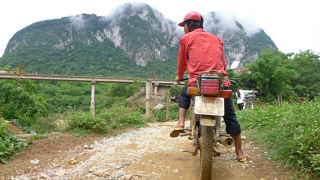

Best Match: 'a man sitting on a motorcycle by the side of a street  with mountains, a bay and bridges in the background'
Similarity : 0.93



In [ ]:
for id in list(img_id_to_file.keys()):
    image_path = os.path.join(image_dir, img_id_to_file[id])
    raw_image = Image.open(image_path).convert("RGB")

    width, height = raw_image.size
    resized_image = raw_image.resize((width // 2, height // 2))
    display(resized_image)

    best_match, scores, best_score = match_caption(image_path, all_captions)
    print(f"Best Match: '{best_match}'")
    print(f"Similarity : {round(best_score, 2)}\n")
    break # run once

Image Classification on CIFAR10 using CLIP

In [ ]:
transform = preprocess # from loading CLIP

# Dataset for Image Classification
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# CIFAR-10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170M/170M [00:09<00:00, 18.8MB/s]


In [ ]:
def classify_image(images):
    # Make captions using labels
    text_inputs = tokenizer([f"a photo of a {c}" for c in class_names]).to(device)

    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        logits = image_features @ text_features.T
        preds = logits.argmax(dim=1)

    return preds

In [ ]:
def show_batch_images(images, labels, class_names, num_images=8):
    images = images[:num_images]
    labels = labels[:num_images]
    images = images.detach().cpu()
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    for i in range(num_images):
        img = images[i].numpy().transpose((1, 2, 0))  # CHW to HWC
        axes[i].imshow(img)
        axes[i].set_title(class_names[labels[i].item()], fontsize=8)
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

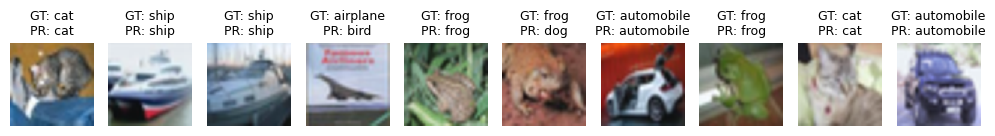

In [ ]:
# Show Image Classification Resault
images, labels = next(iter(testloader))

# De-normalize for visualization
mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(1, 3, 1, 1).to(images.device)
std = torch.tensor([0.2470, 0.2435, 0.2616]).view(1, 3, 1, 1).to(images.device)
images = images * std + mean
images = torch.clamp(images, 0, 1)

# Convert to PIL and apply CLIP preprocessing
to_pil = transforms.ToPILImage()
images_resized = torch.stack([transform(to_pil(img.cpu())) for img in images]).to(device)

# Classify
preds = classify_image(images_resized)

num_plots=10
fig, axes = plt.subplots(1, num_plots, figsize=(10, 2))
for i in range(num_plots):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    axes[i].imshow(img, interpolation='nearest')
    gt = class_names[labels[i]]
    pr = class_names[preds[i]]
    axes[i].set_title(f"GT: {gt}\nPR: {pr}", fontsize=9)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

Comparision of Zero-Shot and Linear Probe

In [ ]:
# Zero-Shot Accuracy for All Images in Test Set of CIFAR10
def zero_shot_accuracy():
    text_inputs = tokenizer([f"a photo of a {c}" for c in class_names]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    num_correct, num_total = 0, 0
    for images, labels in tqdm(testloader, desc="Zero-Shot"):
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            logits = image_features @ text_features.T
            preds = logits.argmax(dim=1)

        num_correct += (preds == labels).sum().item()
        num_total += labels.size(0)

    accuracy = 100 * num_correct / num_total
    print(f"Zero-Shot Accuracy: {accuracy:.2f}%")
    return

In [ ]:
# Labels and Extracted Features for Linear Prob
def extract_features(dataloader):
    features, targets = [], []
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Extract Features"):
            image_features = model.encode_image(images.to(device))
            features.append(image_features.cpu())
            targets.append(labels)
    return torch.cat(features), torch.cat(targets)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
# Linear Prob Accuracy
def linear_prob_accuracy(train_features, train_labels, test_features, test_labels):
    lp_model = nn.Linear(train_features.size(1), 10).to(device)
    optimizer = optim.Adam(lp_model.parameters(), lr=1e-3)

    train_features, train_labels = train_features.to(device), train_labels.to(device)

    #Train on train set
    for epoch in range(10):
        lp_model.train()
        optimizer.zero_grad()
        outputs = lp_model(train_features)
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()
        if epoch % 5 == 0:
          print(f"Epoch {epoch+1} - Loss: {loss.item():.4f}")

    #Test on test set
    lp_model.eval()
    with torch.no_grad():
        test_outputs = lp_model(test_features.to(device))
        preds = test_outputs.argmax(dim=1)
        accuracy = (preds == test_labels.to(device)).float().mean().item() * 100

    print(f"Linear Probe Accuracy: {accuracy:.2f}%")
    return

In [ ]:
# Zero-shot
zero_shot_accuracy()

# Linear probe
train_feats, train_labels = extract_features(trainloader)
test_feats, test_labels = extract_features(testloader)

linear_prob_accuracy(train_feats, train_labels, test_feats, test_labels)

Zero-Shot: 100%|██████████| 157/157 [00:48<00:00,  3.25it/s]


Zero-Shot Accuracy: 86.17%


Extract Features: 100%|██████████| 157/157 [00:47<00:00,  3.28it/s]


Epoch 1 - Loss: 2.3959
Epoch 6 - Loss: 2.1046
Linear Probe Accuracy: 77.33%


Prompt Engineering for CLIP

In [ ]:
prompt_sets = {
    "word": [f"{name}" for name in class_names],
    "a photo of": [f"a photo of {name}" for name in class_names],
    "this is": [f"this is {name}" for name in class_names],
    "long prompts": [f"a high-resolution picture taken by a DSLR camera showing the majestic beauty of the {name} in its location" for name in class_names],
    "bad prompts": [f"the president of the {name}" for name in class_names],
    "completely irrelevant prompts": ["a gourmet dish made with fresh airplane and herbs", "a bedtime story about a magical automobile that sings",
                                     "a financial report on the annual revenue of a bird","a chemistry lecture explaining the atomic structure of a cat",
                                     "a pop song dedicated to the heartbreak caused by a deer","a programming tutorial using the dog language",
                                     "a political debate featuring a controversial frog bill","a smartphone app review about the horse interface",
                                     "an article about climate change and the mating habits of the ship","a skincare routine influenced by the spiritual truck energy"]

}

In [ ]:
for name, prompt_list in prompt_sets.items():
  print(name)
  print(prompt_list)

word
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
a photo of
['a photo of airplane', 'a photo of automobile', 'a photo of bird', 'a photo of cat', 'a photo of deer', 'a photo of dog', 'a photo of frog', 'a photo of horse', 'a photo of ship', 'a photo of truck']
this is
['this is airplane', 'this is automobile', 'this is bird', 'this is cat', 'this is deer', 'this is dog', 'this is frog', 'this is horse', 'this is ship', 'this is truck']
long prompts
['a high-resolution picture taken by a DSLR camera showing the majestic beauty of the airplane in its location', 'a high-resolution picture taken by a DSLR camera showing the majestic beauty of the automobile in its location', 'a high-resolution picture taken by a DSLR camera showing the majestic beauty of the bird in its location', 'a high-resolution picture taken by a DSLR camera showing the majestic beauty of the cat in its location', 'a high-resolution picture taken by a DSLR camera showing 

In [ ]:
def evaluate_prompts(prompts):
    with torch.no_grad():
        tokens = tokenizer(prompts).to(device)
        text_feat = model.encode_text(tokens)
        text_feat /= text_feat.norm(dim=-1, keepdim=True)

        num_correct = 0
        for images, labels in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)
            image_feat = model.encode_image(images)
            image_feat /= image_feat.norm(dim=-1, keepdim=True)
            logits = image_feat @ text_feat.T
            preds = logits.argmax(dim=-1)
            num_correct += (preds == labels).sum().item()
        return num_correct / len(testset)

In [ ]:
# Evaluating each prompt group
for name, prompt_list in prompt_sets.items():
    acc = evaluate_prompts(prompt_list)
    print(f"Accuracy with prompt group '{name}': {acc:.4f}\n")

100%|██████████| 157/157 [00:49<00:00,  3.18it/s]


Accuracy with prompt group 'word': 0.8599



100%|██████████| 157/157 [00:47<00:00,  3.29it/s]


Accuracy with prompt group 'a photo of': 0.8655



100%|██████████| 157/157 [00:47<00:00,  3.30it/s]


Accuracy with prompt group 'this is': 0.8727



100%|██████████| 157/157 [00:47<00:00,  3.30it/s]


Accuracy with prompt group 'long prompts': 0.8690



100%|██████████| 157/157 [00:46<00:00,  3.36it/s]


Accuracy with prompt group 'bad prompts': 0.8705



100%|██████████| 157/157 [00:46<00:00,  3.35it/s]

Accuracy with prompt group 'completely irrelevant prompts': 0.7113

